# Fake and Real News

Model to determine if an article is fake news or not ?

## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

1 Physical GPUs, 1 Logical GPUs


## Load the dataset and validate the data load

We will load the individual dataset, create a target attribute which will indicate 1 if the news is fake. Combine both the dataframes and create the combined dataframe for modelling

In [3]:
# Load the fake and real news datasets
fake_news = pd.read_csv("resources/Fake.csv")
fake_news["fake"] = 1

# Load the real news 
real_news = pd.read_csv("resources/True.csv")
real_news["fake"] = 0

# We will join the two dataframes and create the combined one for modelling

news = pd.concat([fake_news, real_news])
news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [4]:
# Check for any null values
news.isna().sum()

title      0
text       0
subject    0
date       0
fake       0
dtype: int64

In [5]:
# Check the data structure
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


## Exploratory Data Analysis - Data Visualizations

#### Explore the target variable

Distributions...
1    23481
0    21417
Name: fake, dtype: int64


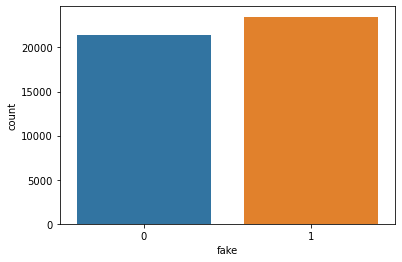

In [6]:
# Explore the target variable
sns.countplot(x='fake', data=news)
print("Distributions...")
print(news['fake'].value_counts())

We see good distibution of data in both the classes

#### Explore at least 2 texts from each class

In [7]:
# Explore 2 texts for the fake dataset
news[news['fake'] == 1]['text'].head(2)

0    Donald Trump just couldn t wish all Americans ...
1    House Intelligence Committee Chairman Devin Nu...
Name: text, dtype: object

In [8]:
# Expore 2 textx for the real news
news[news['fake'] == 0]['text'].head(2)

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
Name: text, dtype: object

#### Explore the Subject column

<AxesSubplot:xlabel='subject', ylabel='count'>

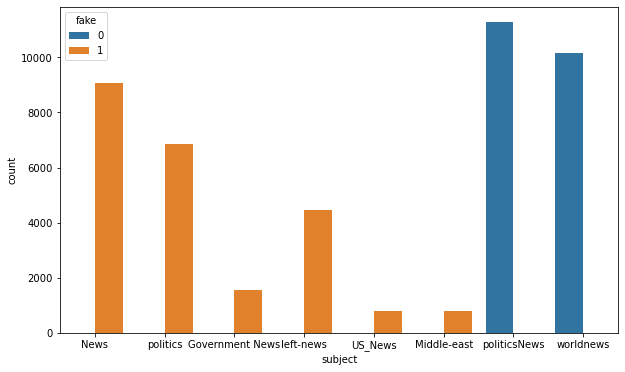

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', data=news, hue='fake')

This clearly shows that any news which is not of "policticsNews or worldnews" is a fake news. This perfectly seggregates the data into two classes and hence is not a choice for classification modelling. We would drop this attribute before we begin modelling

## Feature Engineering

#### We will create a new columns called Month and Year from Date and analyse whether fake or real news has some correlation with Month or Year in the timeline

In [10]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month

news.head()

,title,text,subject,date,fake,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,1,2017.0,12.0


<AxesSubplot:xlabel='Year', ylabel='count'>

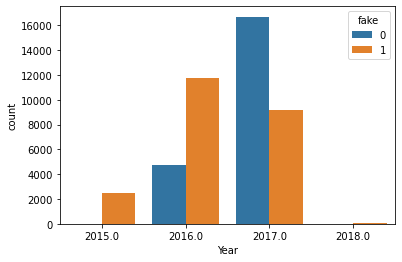

In [11]:
# Check the impact of Year on the target variable
sns.countplot(x='Year', data=news, hue='fake')

All news in the year 2015 in the dataset is a fake news. So this attribute has a level which perfectly distributes the target variable.

<AxesSubplot:xlabel='Month', ylabel='count'>

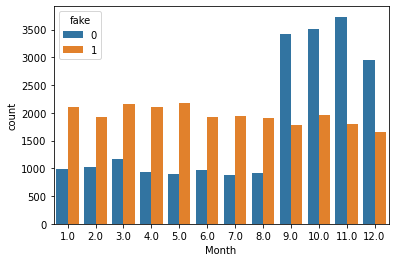

In [12]:
# Check the impact of Month on the target variable
sns.countplot(x='Month', data=news, hue='fake')

This shows an interesting pattern - The number of fake news is higher till month 8, post which the number of real news increases drastically. Which essentially means if the month is <= 8, the probability of fake news is higher. 

#### We will combine the title and text column

In [13]:
news['text'] = news['title'] + news['text']
news.drop(labels=['title'], axis=1, inplace=True)

news.head()

,text,subject,date,fake,Year,Month
0,Donald Trump Sends Out Embarrassing New Year’...,News,2017-12-31,1,2017.0,12.0
1,Drunk Bragging Trump Staffer Started Russian ...,News,2017-12-31,1,2017.0,12.0
2,Sheriff David Clarke Becomes An Internet Joke...,News,2017-12-30,1,2017.0,12.0
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,2017-12-29,1,2017.0,12.0
4,Pope Francis Just Called Out Donald Trump Dur...,News,2017-12-25,1,2017.0,12.0


## Preparing the final data

We will remove the subject attribute - Since it perfectly distributes the target variable
We will remove the Year attribute - This also has a clear division for the target variable
We will remove the Month Attribute - This also has a very clear approach of demarcating the target variable

For now we will just go ahead with the "text attribute"

In [14]:
news.drop(labels=['subject', 'date', 'Year', 'Month'], axis=1, inplace=True)
news.head()

,text,fake
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1


## Train-Test Split

In [23]:
# We will shuffle the dataframe and extract the feature and label

news = news.sample(frac=1)
feature_text = news['text']
target = news['fake']

In [30]:
# Perform the split

from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(feature_text, target, test_size=0.2, 
                                                                            random_state=101)

# We will further split the training set into validatoion to evaluate the Neural Network training
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.3, 
                                                                            random_state=101)

print("Training Features shape: ", features_train.shape)
print("Training Target shape: ", target_train.shape)

print("Validation Features shape: ", features_val.shape)
print("Validation Target shape: ", target_val.shape)

print("Test Features shape: ", features_test.shape)
print("Training Target shape: ", target_test.shape)

Training Features shape:  (25142,)
Training Target shape:  (25142,)
Validation Features shape:  (10776,)
Validation Target shape:  (10776,)
Test Features shape:  (8980,)
Training Target shape:  (8980,)


In [25]:
# First 10 training samples
features_train[: 10]

22710    Bundy Case Ruled a Mistrial – Will Federal Cas...
11511    WATCH: G.W. BUSH Gushes Over Kimmel’s Anti-Tru...
6295      Trump Campaign Accidentally Reveals How Donal...
11616    International reaction to arrest of Reuters re...
232      Trump lifts refugee ban, but admissions still ...
20930    Trump, UK's May agree that China must do more ...
11495    Ukraine's Poroshenko vows to work for quick ex...
15690    European nations condemn detention of lawyer i...
14200    OBAMA’S BACKDOOR GUN CONFISCATION: 260,000 VET...
1785      Local Fox Affiliate Just Gave Fox News A GIAN...
Name: text, dtype: object

In [26]:
# First 10 training classes (target)
target_train[: 10]

22710    1
11511    1
6295     1
11616    0
232      0
20930    0
11495    0
15690    0
14200    1
1785     1
Name: fake, dtype: int64

## Build and Train the Neural Network Model

In [40]:
# Define the Model Constants

INPUT_SHAPE = []

OUTPUT_UNITS = 1
HIDDEN_UNITS = 16
ACTIVATION_HIDDEN = tf.keras.activations.relu
ACTIVATION_OUTPUT = tf.keras.activations.sigmoid
LEARNING_RATE = 1e-3
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
LOSS_FUNCTION = tf.keras.losses.BinaryCrossentropy(from_logits=True)
DROPOUT_RATE = 0.5

EPOCHS = 10

In [35]:
# Define the Metrics - These are the metrics we will evaluate during training

METRICS = [tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')]

#### In order to perform text processing, we would be using a pre-trained embedding layer from tensorflow-hub

We will create a Keras Layer that uses tensorflow hub model to embed sentences

In [34]:
model = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(model, input_shape=INPUT_SHAPE, dtype=tf.string, trainable=True)

# We will train it in the first two samples and check
hub_layer(features_train[:2])

<tf.Tensor: shape=(2, 128), dtype=float32, numpy=
array([[ 2.88452244e+00, -1.82624355e-01,  1.63414329e-01,
         2.81597257e-01,  1.68646872e-01, -3.39296162e-01,
         2.83816736e-02, -3.53355914e-01, -4.44529951e-01,
         1.81659073e-01,  5.74824572e-01, -6.48341998e-02,
        -7.04668343e-01, -4.40782964e-01, -4.51589257e-01,
         7.95162693e-02, -6.17053151e-01, -5.33940084e-02,
        -1.86176933e-02,  1.88583970e+00,  4.58104983e-02,
         2.33056515e-01, -1.04254819e-01, -3.82346839e-01,
        -2.01086760e-01, -3.62083763e-01,  6.76294625e-01,
        -4.80321841e-03, -4.32810515e-01,  5.91320321e-02,
        -1.89389691e-01,  1.40063316e-01,  5.80955684e-01,
        -2.76259124e-01,  3.17460485e-02, -4.38250899e-01,
        -2.21831441e-01, -5.67336619e-01, -5.25629893e-03,
         6.68723702e-01, -5.77379763e-02,  2.30284184e-02,
        -2.30660960e-01,  4.03043553e-02,  2.21579626e-01,
         6.74872339e-01,  1.19847946e-01,  3.85565132e-01,
      

#### Building the complete Model

In [ ]:
# The model is sequential
model = tf.keras.Sequential()

# Add the hub layer as the input layer
model.add(hub_layer)

# Add a hidden layer
model.add(tf.keras.layers.Dense())

In [37]:
# Defining a function which will build and compile the model

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN))
    model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [38]:
# Lets build the model and see the mmodel summary

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


#### Training the model

In [41]:
# we will now train the model on training and validation data

epochs_history = model.fit(features_train, target_train, epochs=EPOCHS,
                          validation_data=(features_val, target_val),
                          verbose=1)

Epoch 1/30
786/786 [==============================] - 50s 61ms/step - loss: 0.0563 - tp: 12995.0000 - fp: 163.0000 - tn: 11785.0000 - fn: 199.0000 - accuracy: 0.9856 - precision: 0.9876 - recall: 0.9849 - auc: 0.9989 - val_loss: 0.0105 - val_tp: 5633.0000 - val_fp: 6.0000 - val_tn: 5104.0000 - val_fn: 33.0000 - val_accuracy: 0.9964 - val_precision: 0.9989 - val_recall: 0.9942 - val_auc: 0.9999
Epoch 2/30
786/786 [==============================] - 46s 59ms/step - loss: 9.6325e-04 - tp: 13192.0000 - fp: 3.0000 - tn: 11945.0000 - fn: 2.0000 - accuracy: 0.9998 - precision: 0.9998 - recall: 0.9998 - auc: 1.0000 - val_loss: 0.0087 - val_tp: 5642.0000 - val_fp: 10.0000 - val_tn: 5100.0000 - val_fn: 24.0000 - val_accuracy: 0.9968 - val_precision: 0.9982 - val_recall: 0.9958 - val_auc: 0.9998
Epoch 3/30
786/786 [==============================] - 47s 59ms/step - loss: 1.3496e-04 - tp: 13194.0000 - fp: 0.0000e+00 - tn: 11948.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1

KeyboardInterrupt: 